<a href="https://colab.research.google.com/github/Alex201215/GPH-2004/blob/master/TpopDonnees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import des packages nécessaires pour MNIST



In [39]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

print(torch.__version__)
#print(torchvision.__version__)

2.2.1+cu121


In [32]:
traindata = MNIST(root="data",
                  train=True,
                  download = True,
                  transform = ToTensor())

testdata = MNIST(root="data",
                  train=False,
                  download = True,
                  transform = ToTensor())

La base de données est donc importée, on veut maintenant les affichers (pour des raisons de test)



In [76]:
class_names = traindata.classes
print(len(testdata), len(traindata)) # Costaud !
image, label = traindata[0]
#print(image)
traindata, testdata

10000 60000


(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

*On* veut afficher ces données avec matplotlib. Squeeze prends ton image et enlève une dimension (prends un tenseur enlève une dimension au tenseur). Et cmap="gray" prends ton image et la met sur une échelle noir et blanc

3
torch.Size([1, 28, 28])
2
torch.Size([28, 28])


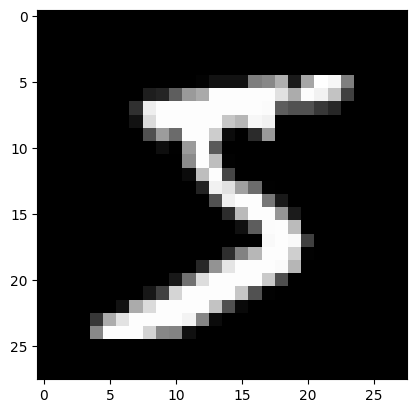

In [34]:
plt.imshow(image.squeeze(), cmap="gray")
print(image.ndim) # Image a 3 dimensions
print(image.shape)

image_squeezed = image.squeeze(dim=0)
print(image_squeezed.ndim)
print(image_squeezed.shape)

Voici donc l'une des images (première image du tension de traindata). On commence maintenant le code pour entraîner l'algorithme. En ce moment on a du data en TorchDataset. We want to turn our data into mini batches. On fait ça car ton hardware n'arrive pas à lire autant d'images de la mémoire. Tu veux aussi donner plus de chances à ton réseaux de neuronnes d'update par epoch (Whatever epoch is). On fait donc des batch de 32.

Ensuite, DataLoader va rendre notre dataset itérable (batch de 32)

In [35]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=traindata,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=testdata,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7dc952054be0>,
 <torch.utils.data.dataloader.DataLoader at 0x7dc952056dd0>)

In [40]:
# Let's check out what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7dc952054be0>, <torch.utils.data.dataloader.DataLoader object at 0x7dc952056dd0>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


Dernier dataloader a pas exactement 313 batches. C'est 312.5 mais rounded out.

In [65]:
# Features = images, Label = target
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape
# Nb d'images, Color channel, size, size
# Color channel indice qui donne info couleurs

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 9, label size: torch.Size([])


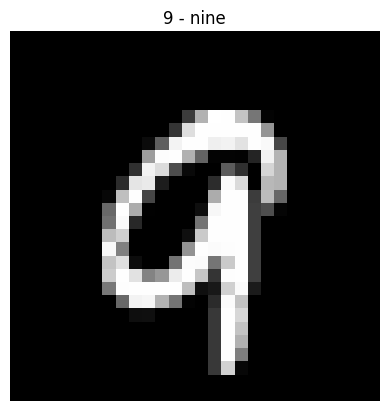

In [81]:
# Show a sample (n'importe quel, d'où le randint)
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

Maintenant qu'on a des dataLoaders, il faut un modèle qui peut learn de tous ces dataLoaders. L'étape suivante est donc la création du modèle qui permet de prendre les dataLoaders et apprendre de ceux-ci.

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiemtns, it\'s best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [94]:
from torch import nn

# Create a flatten layer ()
flatten_model = nn.Flatten()


# Get a single sample (C'est un tenseur qui continent l'information de l'image)
x = train_features_batch[0]
x.shape

# Flatten the sample
output = flatten_model(x) # perform forward pass

#print out what hapenned (Tu enlève une dimension au tenseur (tu merge deux dim en 1))
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}") # 28*28 = 784


Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [109]:
class TpopMNISTModelV0(nn.Module):

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape) # modèle suggère aucune non-linéarité
    )

  def forward(self, x):
    return self.layer_stack(x) # x is a batch at a time

